 # Ptychographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

## Worklog
- 20240308: Start working on this
- 20240310: Got
- 20240311: Implemented mixed object and unified dimension for 2D and 3D
- 20240313: Tried position correction, need to do it with real-valued object. Switch to 2 channels.

## TODO

### Correction
- Add probe position correction
- Multi-object reconstruction?

### Optimization
- Add regularization / constraint / multiscale consistence loss
- Split into 2 amp and phase channels
- Multiscale pyramidal reconstruction
- Specify MLs / MLc

### Initialization
- Add loading initial guess
- Add object and probe initialization (probe modes)

### Input / Output
- Add saving intermediate results
- 
- Add checkpoints



In [1]:
# Import 
import sys
sys.path.append('H:\workspace')
from p01_code.io_4D_data import load_fields_from_mat, load_hdf5, load_empad_as_4D
from p01_code.simulate_STEM_probe import simulate_STEM_probe
from p01_code.complex_object_interp3d import complex_object_interp3d
from p01_code.find_reconstruction_ROI_external import find_reconstruction_ROI_external
from p01_code.near_field_evolution import near_field_evolution
from preprocess import preprocess_CBED, preprocess_ptycho_output_dict 
from optimization import cbed_rmse
from visualization import plot_recon_progress
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.fft import fft2, ifft2, fftshift

GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Importing from p01_code
Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [2]:
# Setup data path
#ptycho_output_mat_path = "data/data3D_300kV_df_20nm_alpha_21.4mrad_Cs_0.0um_dp_128_blur_0px_dose_1.0e+08ePerAng2/1/roi_1_Ndp_128/MLs_L1_p4_g32_Ns21_dz10_reg1_dec0.92_dpFlip_T/Niter500.mat"
#exp_CBED_path = "data/data3D_300kV_df_20nm_alpha_21.4mrad_Cs_0.0um_dp_128_blur_0px_dose_1.0e+08ePerAng2/1/data_roi_1_Ndp_128_dp.hdf5"

# Exp PSO
# ptycho_output_mat_path = "data/MLs_L1_p8_g192_Ndp128_pc50_noModel_vp1_Ns21_dz10_reg1/Niter200.mat"
# exp_CBED_path = "data/MLs_L1_p8_g192_Ndp128_pc50_noModel_vp1_Ns21_dz10_reg1/PSO_data_roi0_Ndp256_dp.hdf5"

# Exp PSO
# ptycho_output_mat_path = "data/MLs_L1_p4_g32_Ns21_dz10_dpFlip_T/Niter50_ML.mat"
# exp_CBED_path = "data/MLs_L1_p4_g32_Ns21_dz10_dpFlip_T/data_roi_1_Ndp_128_dp.hdf5"

ptycho_output_mat_path = "data/Fig_1h_24.9mrad_Themis/1/roi1_Ndp128_step128\MLs_L1_p10_g128_pc0_noModel_updW100_mm_dpFlip_ud_T/Niter9000_v7.mat"
exp_CBED_path =          "data/Fig_1h_24.9mrad_Themis/1/data_roi1_Ndp128_step128_dp.hdf5"



print("Loading ptycho output and experimental CBED")
ptycho_output_dict = load_fields_from_mat(ptycho_output_mat_path, 'All', squeeze_me=True, simplify_cells=True)
#exp_CBED = load_empad_as_4D(exp_CBED_path, 128,130,128,128,'C')
exp_CBED, CBED_source = load_hdf5(exp_CBED_path, dataset_key='dp') 
# Note that loading Matlab-generated F-order HDF5 (kx, ky, Nscan) into Python would automatically make it C-order (Nscan, ky, kx)

Loading ptycho output and experimental CBED
Success! .mat File path = data/Fig_1h_24.9mrad_Themis/1/roi1_Ndp128_step128\MLs_L1_p10_g128_pc0_noModel_updW100_mm_dpFlip_ud_T/Niter9000_v7.mat
Success! hdf5 File path = data/Fig_1h_24.9mrad_Themis/1/data_roi1_Ndp128_step128_dp.hdf5
Imported hdf5 data shape = (16384, 128, 128)


In [3]:
# Preprocessing and setting up the data dimension

print("Preprocessing ptycho output and experimental CBED\n")
probe, object, exp_params = preprocess_ptycho_output_dict(ptycho_output_dict)
y_true                    = np.flip(exp_CBED, axis=1) # preprocess_CBED(exp_CBED) # (Nscan, ky, kx) that matches the .tif view
y_true[y_true<0] = 0
#y_true = np.reshape(y_true, (128*128,128,128))/151

# Prepare the experimental param for forward model and dataset generation
lambd           = exp_params['lambd']
dx_spec         = exp_params['dx_spec']
z_distance      = 1 #exp_params['z_distance_arr'][0] # Modify for 2D input
probe_positions = exp_params['probe_positions']
Nlayer          = exp_params['Nlayer']
N_scans         = exp_params['N_scans']

# Preprocessing variables for simulated PSO
object = object[None, :,:]#object.transpose((2,0,1)) # Converting object into (Nz, Ny, Nx)
probe = probe.transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)

# Preprocessing variables for tBL-WSe2 with Themis
#object = object[None,:,:] # Converting object into (Nz, Ny, Nx)
#probe = probe[:,:,:,0].transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)
print(f"object.shape = {object.shape}, probe.shape = {probe.shape}")

Preprocessing ptycho output and experimental CBED

Handling single slice ptycho .mat
`z_distance_arr` and `Nlayer` is populted with 1 and 1
object.shape = (1, 592, 592), probe.shape = (10, 128, 128)


In [4]:
# Preprocessing and setting up the data dimension

# print("Preprocessing ptycho output and experimental CBED\n")
# probe, object, exp_params = preprocess_ptycho_output_dict(ptycho_output_dict)
# y_true                    = preprocess_CBED(exp_CBED) # (Nscan, ky, kx) that matches the .tif view

# # Prepare the experimental param for forward model and dataset generation
# lambd           = exp_params['lambd']
# dx_spec         = exp_params['dx_spec']
# z_distance      = exp_params['z_distance_arr'][0]
# probe_positions = exp_params['probe_positions']
# Nlayer          = exp_params['Nlayer']
# N_scans         = exp_params['N_scans']

# Preprocessing variables for simulated PSO
#object = object.transpose((2,0,1)) # Converting object into (Nz, Ny, Nx)
#probe = probe.transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)


# Reslice the z slices
final_z = 8 # z slices #21 for PSO
z_zoom = 8 #final_z / Nlayer
z_distance = z_distance  #z_distance / z_zoom #no need to do scaling if we're starting from 2D object
object = complex_object_interp3d(object, (z_zoom, 1, 1), z_axis = 0, use_np_or_cp = 'np') # Use cp for faster interpolation and convert it back to np with .get() as a default postprocessing

# Calculate the crop coordinates and shift vector for sub-px probe shift
probe_positions = probe_positions[:, [1,0]] # The first index after shifting is the row index (along vertical axis)
crop_coordinates = probe_positions + np.ceil((object.shape[-1]/2) - (probe.shape[-1]/2)) - 1 # For Matlab - Python index shift
sub_px_shift = crop_coordinates - np.round(crop_coordinates)
shift_vec = np.zeros((N_scans, 3), dtype=np.float32)
shift_vec[:, 1:] = np.array(sub_px_shift)
crop_coordinates_with_idx = np.concatenate((np.arange(N_scans).reshape(-1,1), crop_coordinates), axis=1)

## Calculate propagator for multislice forward model
extent = dx_spec * np.array(probe.shape[-2:])
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')

# Specify forward model accuracy options
N_max = 16384
use_sub_px_probe_shift = None # fourier, real, None. Honestly I don't think this is that important
pmode_max = 10 # 4
omode_max = 1 # By default we only do 1 object mode

# Initialize probe / object if needed (expand them to desired dimension)
if object.ndim == 2:
      # (Ny, Nx) for 2D ptychography
      object_data = object[None, :, :]
      print(f"Expanding 2D object (Ny, Nx) from {object.shape} to 3D object (Nz, Ny, Nx) {object_data.shape}")
elif object.ndim == 3:
      # (Nz, Ny, Nx) for multislice (3D) ptycho
      object_data = object
      print(f"Object is already 3D (Nz, Ny, Nx) with {object_data.shape}")

obj_power_factor = np.exp(np.log(0.02)/2/final_z) # Multiply the object by this factor would result a 2% total scattering intensity in the CBED after all the loss from all multiplicative slices

object_data = np.stack([object_data if i < 1 else gaussian_filter(object_data, sigma = (0,i//2, i%2)) * obj_power_factor for i in range(omode_max)], axis=0).astype('complex128') # Adding gaussian blur to the obj modes
probe_data = probe[:pmode_max, :, :].astype('complex128')
ground_truth_data = y_true[:N_max].astype('float64')
crop_coordinates_with_idx = crop_coordinates_with_idx[:N_max]

# Shuffle the cropping sequence is easier than shuffling the entire dataset
use_shuffled_data = False
if use_shuffled_data:
      np.random.seed(42)
      np.random.shuffle(crop_coordinates_with_idx)
      print("The cropping order is shuffled!")
print(f"\nFirst 5 sample idx = {crop_coordinates_with_idx[:5,0]}")
      
print(f"object_data dtype/shape (omode, Nz, Ny, Nx) = {object_data.dtype}, {object_data.shape}, \
      \nprobe_data dtype/shape      (pmode, Ny, Nx) = {probe_data.dtype}, {probe_data.shape}, \
      \nground_truth_data dtype/shape      (Ky, Kx) = {ground_truth_data.dtype}, {ground_truth_data.shape}, \
      \nH dtype/shape                      (Ky, Kx) = {H.dtype}, {H.shape}")

The object shape is interpolated to (8, 592, 592).
Object is already 3D (Nz, Ny, Nx) with (8, 592, 592)

First 5 sample idx = [0. 1. 2. 3. 4.]
object_data dtype/shape (omode, Nz, Ny, Nx) = complex128, (1, 8, 592, 592),       
probe_data dtype/shape      (pmode, Ny, Nx) = complex128, (10, 128, 128),       
ground_truth_data dtype/shape      (Ky, Kx) = float64, (16384, 128, 128),       
H dtype/shape                      (Ky, Kx) = complex128, (128, 128)


### Note: Everything is still np array (complex) from this cell, it'll be converted to tensor later

Additionally, the object tensor would need another dimension to store amplitude and phase for the affine transformation

In [5]:
def cplx_from_2_arr(re, im, ndim):
    '''Stack two tensor on a new dimension'''
    # re: real-valued torch Tensor representing the real part of the final pseudo-complex torch Tensor
    # im: real-valued torch Tensor representing the imag part of the final pseudo-complex torch Tensor
    # ndim: The axis that stacks the real and imag part
    re, im = re.unsqueeze(ndim), im.unsqueeze(ndim)
    return torch.cat((re, im), ndim)

def cplx_from_np(a, cplx_type, ndim):
    """Transform a complex numpy array in a "complex" tensor"""
    # a: Input complex np array
    # ndim: The axis that stacks the real/imag or amp/phase part
    # cplx_type: "real_imag" or "amp_phase"
    
    if cplx_type == "real_imag":
        return cplx_from_2_arr(torch.from_numpy(a).real, torch.from_numpy(a).imag, ndim)
    elif cplx_type == "amp_phase":
        return cplx_from_2_arr(torch.from_numpy(a).abs(), torch.from_numpy(a).angle(), ndim)

def cplx_mul_2d(h, k):
    """Complex element-wise multiplication between two tensor"""
    # h, k: input pseudo-complex torch Tensor
    # Assuming the last dimension corresponds to the real (0) and imag (1) part
    a, b = h[...,0], h[...,1]
    c, d = k[...,0], k[...,1]
    return cplx_from_2_arr(a*c-b*d, a*d+b*c)

In [6]:
## Defining forward model

def multislice_forward_model_broadcast_pmode_omode(object, probe, H):
    
    # object (omode, Nz, Ny, Nx, 2), pseudo-complex tensor with float64
    # probe (pmode, Ny, Nx), tensor with complex128
    # H (Ky, Kx), tensor with complex128
    
    object_cplx = torch.polar(object[...,0], object[...,1]) # Cast the object back to complex
    n_slices = object_cplx.shape[1]
    
    # Expand psi to includ omode dimension
    psi = probe 
    psi = psi[:,None, :, :] # (pmode, Ny, Nx) -> (pmode, omode, Ny, Nx)

    # Propagating each object layer
    for n in range(n_slices):
        object_slice = object_cplx[:, n, :, :] # object_slice.shape -> (omode, Ny, Nx)
        
        psi = psi * object_slice[None, :, :, :]  # psi.shape -> (pmode, omode, Ny, Nx)
        if n < n_slices - 1:
            psi = ifft2(H * fft2(psi, dim=(-2, -1)), dim=(-2, -1))

    # Note that in PyTorch fft2 is applied to all dimensions by default
    dp_fwd = torch.sum(torch.square(torch.abs(fftshift(fft2(psi, dim=(-2, -1)), dim=(-2, -1)))), dim=(0, 1))
    return dp_fwd



## Build the model object

In [7]:
# def normalize_transforms(transforms, W,H):
#     transforms[0,0] = transforms[0,0]
#     transforms[0,1] = transforms[0,1]*H/W
#     transforms[0,2] = transforms[0,2]*2/W + transforms[0,0] + transforms[0,1] - 1

#     transforms[1,0] = transforms[1,0]*W/H
#     transforms[1,1] = transforms[1,1]
#     transforms[1,2] = transforms[1,2]*2/H + transforms[1,0] + transforms[1,1] - 1

#     return transforms


# def prepare_stack_tranform(pos, imgshape):
#     # prepare the transforms
#     # This function generates a stack of affine transformaitons
#     # Each affine transform corresponds to an input position
#     M  = torch.zeros(len(pos), 1, 2, 3)
#     for idx, (cy, cx) in enumerate(pos):
#         Mn = np.asarray([[1.,0,cy],[0,1.,cx],[0,0,1.]]).astype(np.float32)
#         Mn = normalize_transforms(Mn[0:2,:], imgshape[0], imgshape[1])
#         M[idx] = torch.from_numpy(Mn).unsqueeze(0) # unsqueeze(0) will add a singleton at the front
#     return M

In [8]:


# class PtychoAD(torch.nn.Module):
#     def __init__(self, objguess, probeguess, crop_coordinates, H):
#         super(PtychoAD, self).__init__()
#         with torch.no_grad():
#             self.objguess = torch.tensor(objguess, device=DEVICE, dtype=torch.complex128)
#             self.probeguess = torch.tensor(probeguess, device=DEVICE, dtype=torch.complex128)
#             self.H = torch.tensor(H, device=DEVICE, dtype=torch.complex128)
#             self.crop_coordinates = (prepare_stack_tranform(crop_coordinates, objguess.shape)).double().cuda()
# #            self.crop_coordinates = torch.tensor(crop_coordinates, device=DEVICE, dtype=torch.float32)
#             self.crop_coordinates_coeff = torch.zeros_like(self.crop_coordinates, device=DEVICE)
#             self.roi_shape = probeguess.shape[-2:]

#         self.objguess.requires_grad = True
#         self.probeguess.requires_grad = True
#         self.crop_coordinates_coeff.requires_grad = True

                
#         print('obj', self.objguess.dtype, self.objguess.shape)
#         print('probe', self.probeguess.dtype, self.probeguess.shape)
#         print('crop_coordinates', self.crop_coordinates.dtype, self.probeguess.shape)
    
#     def get_obj_ROI(self, idx):

#         patch_shape = (self.roi_shape[0], self.roi_shape[1])
#         cM = self.crop_coordinates[idx] + self.crop_coordinates_coeff[idx]
#         grid = torch.nn.functional.affine_grid(cM, self.objguess.size(), align_corners = False)
#         y = torch.nn.functional.grid_sample(self.objguess, grid, align_corners=False)
#         object_patch =  y[0,:, :patch_shape[0],:patch_shape[1]]
        
#         print(f"y.shape = {y.shape}")
                
#         return object_patch


#     def forward(self, idx):
#         objproj = self.get_obj_ROI(idx)
        
#         dp_fwd = multislice_forward_model_broadcast_pmode_omode(objproj, self.probeguess, self.H)
        
#         return dp_fwd

In [9]:

class PtychoAD(torch.nn.Module):
    def __init__(self, objguess, probeguess, crop_coordinates, H):
        super(PtychoAD, self).__init__()
        with torch.no_grad():
            #self.objguess = torch.tensor(objguess, device=DEVICE, dtype=torch.complex128)
            self.objguess = cplx_from_np(objguess, cplx_type="amp_phase", ndim=-1).to(DEVICE)
            self.probeguess = torch.tensor(probeguess, device=DEVICE, dtype=torch.complex128)
            self.H = torch.tensor(H, device=DEVICE, dtype=torch.complex128)
            self.crop_coordinates = torch.tensor(crop_coordinates, device=DEVICE, dtype=torch.int32)
            self.roi_shape = probeguess.shape[-2:]

        self.objguess.requires_grad = True
        #self.probeguess.requires_grad = True
        #self.crop_coordinates.requires_grad = True
        
        print('obj', self.objguess.dtype, self.objguess.shape)
        print('probe', self.probeguess.dtype, self.probeguess.shape)
        #print('crop_coordinates', self.crop_coordinates.dtype, self.probeguess.shape)

    def get_obj_ROI(self, idx):
        
        coord_with_idx = self.crop_coordinates[idx]

        row_start, column_start = coord_with_idx[0], coord_with_idx[1]
        row_end, column_end = row_start + self.roi_shape[0], column_start + self.roi_shape[1]
        object_patch = self.objguess[...,row_start:row_end, column_start:column_end,:] 
        
        return object_patch


    def forward(self, idx):
        objproj = self.get_obj_ROI(idx)
        
        dp_fwd = multislice_forward_model_broadcast_pmode_omode(objproj, self.probeguess, self.H)
        
        return dp_fwd

## Main optimization loop

In [10]:
data = torch.from_numpy(ground_truth_data).cuda()
#objguess = object_data
objguess = np.exp(1j * 0.05*np.random.rand(*object_data.shape))
probeguess = probe_data
model = PtychoAD(objguess, probeguess, crop_coordinates, H)

modelparams_par = [{"params": model.objguess, "lr":1e-2
                    }] #,                    {"params": model.probeguess, "lr": 1e-2}

opt = torch.optim.Adam(modelparams_par)

obj torch.float64 torch.Size([1, 8, 592, 592, 2])
probe torch.complex128 torch.Size([10, 128, 128])


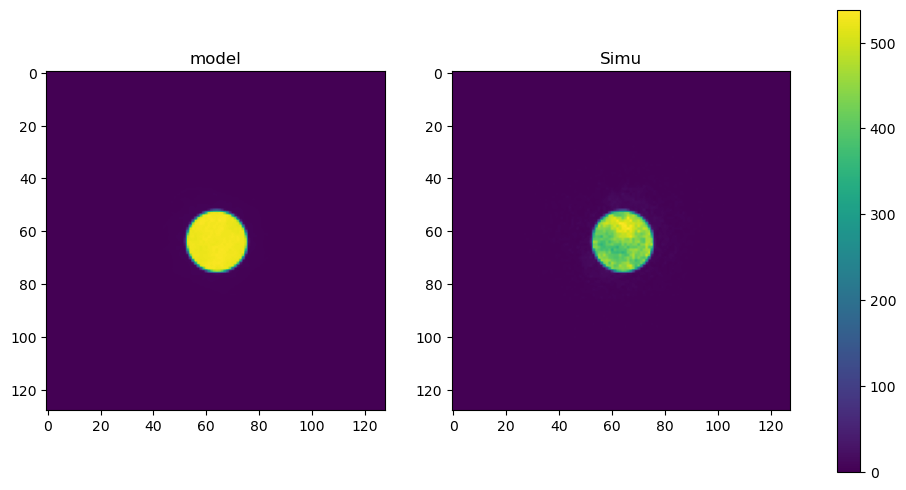

In [26]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(model(i).detach().cpu())
axs[0].set_title("model")
im = axs[1].imshow(ground_truth_data[i])
axs[1].set_title("Simu")
fig.colorbar(im, ax=axs)
plt.show()

In [14]:
from time import time
from IPython.display import clear_output

NITER = 30
BATCH_SIZE = 64 #64
num_batch = len(data)/BATCH_SIZE
tothist = []



for iter in range(NITER):
    error_hist = []
    idxlist = np.random.choice(data.shape[0], data.shape[0], replace=False)

    batches = np.array_split(idxlist, num_batch)

    for batch_num, batch in enumerate(batches):
        start_batch_t = time()
        
        opt.zero_grad()
        
        loss = []
        model_CBEDs = []
        gt_CBEDs = []
        for idx in batch:
            model_CBEDs.append(model(idx))
            gt_CBEDs.append(data[idx])
            
        loss_single = sum([cbed_rmse(model_CBEDs[i].sqrt(), gt_CBEDs[i].sqrt()) for i in range(BATCH_SIZE)])
        loss_batch =   cbed_rmse(sum(model_CBEDs).pow(0.5), sum(gt_CBEDs).pow(0.5)) * BATCH_SIZE**0.5
        loss_total = loss_single + loss_batch
        
        print(f"Iter: {iter}, Batch: {batch_num}, Loss_total: {loss_total}, Loss_single: {loss_single}, Loss_batch: {loss_batch}")
        
        error_hist.append(loss_total.item())
        loss_total.backward()
        opt.step()
        end_batch_t = time()
            
        # #Update the plots after each update
        # AD_image = np.angle(model.objguess.detach().cpu()).sum(1)
        # Input_image = np.angle(object_data).sum(axis=1)[0]

        # # Show the figure per batch
        # clear_output(wait=True)
        # fig = plot_recon_progress(iter, batch_num, AD_image, Input_image)
        # plt.show()
        
        print(f"Done batch {batch_num} in iter {iter} in {(end_batch_t - start_batch_t):.1f} sec", flush=True)
        
    tothist.append(sum(error_hist))
    print('Iter: {} Loss: {} '.format(iter, tothist[-1]), flush=True)



Iter: 0, Batch: 0, Loss_total: 51.39177699543863, Loss_single: 30.48433909618587, Loss_batch: 20.907437899252763
Done batch 0 in iter 0 in 2.3 sec
Iter: 0, Batch: 1, Loss_total: 48.62393751181426, Loss_single: 31.450526605892776, Loss_batch: 17.173410905921482
Done batch 1 in iter 0 in 2.5 sec
Iter: 0, Batch: 2, Loss_total: 44.27069407375437, Loss_single: 31.445427854489186, Loss_batch: 12.825266219265181
Done batch 2 in iter 0 in 2.5 sec
Iter: 0, Batch: 3, Loss_total: 40.76753821178376, Loss_single: 32.0857028544566, Loss_batch: 8.681835357327158
Done batch 3 in iter 0 in 2.4 sec
Iter: 0, Batch: 4, Loss_total: 43.40569272086261, Loss_single: 33.470842075642985, Loss_batch: 9.934850645219628
Done batch 4 in iter 0 in 2.5 sec
Iter: 0, Batch: 5, Loss_total: 41.992912588140896, Loss_single: 34.1221622256404, Loss_batch: 7.870750362500498
Done batch 5 in iter 0 in 2.4 sec
Iter: 0, Batch: 6, Loss_total: 39.60399905009408, Loss_single: 32.572123435989965, Loss_batch: 7.031875614104118
Done b

KeyboardInterrupt: 

In [ ]:
# Plot after each update
fig, axs = plt.subplots(1, 4, figsize=(26, 8))

AD_image = np.angle(model.objguess.detach().cpu()).sum(1)
Input_image = np.angle(object_data).sum(axis=1)[0]

# Determine the common display range
vmin, vmax = np.min(Input_image), np.max(Input_image)

# Plot the first image on the left
axs[0].imshow(AD_image[0], cmap='viridis',  vmin=vmin, vmax=vmax)
axs[0].set_title('AD image mode 0')

axs[1].imshow(AD_image[1], cmap='viridis',  vmin=vmin, vmax=vmax)
axs[1].set_title('AD image mode 1')

axs[2].imshow(AD_image[2], cmap='viridis',  vmin=vmin, vmax=vmax)
axs[2].set_title('AD image mode 2')

# Plot the second image on the right
im3 = axs[3].imshow(Input_image, cmap='viridis',  vmin=vmin, vmax=vmax)  # Change the cmap as needed
axs[3].set_title('Input image')


cbar = fig.colorbar(im3, ax=axs, orientation='vertical', shrink=0.6)

# Show the figure
plt.show()

In [ ]:
from tifffile import imwrite
imwrite("AD_image_multiobj2.tif", np.angle(model.objguess.detach().cpu().numpy())[2].astype('float32'))